In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [11]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]

# Scaling pixels to a 0-1 range helps the gradients stay small and stable.
X_train = X_train / 255.
X_dev = X_dev / 255.

In [46]:
import numpy as np

def init_params():
    """
    INITIALIZATION
    Generates weights (W) and biases (b) for a 2-layer network.
    - Layer 1: 784 inputs (pixels) -> 10 hidden units.
    - Layer 2: 10 hidden units -> 10 outputs (digits 0-9).
    - Subtraction of 0.5 centers the initial weights around zero.
    """
    W1 = np.random.randn(10, 784) * np.sqrt(2. / 784)
    b1 = np.zeros((10, 1)) # Starting biases at 0 is standard
    W2 = np.random.randn(10, 10) * np.sqrt(2. / 10)
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    """
    RECTIFIED LINEAR UNIT (Activation Function)
    Returns Z if Z > 0, otherwise returns 0. 
    Introduces non-linearity, allowing the network to learn complex patterns.
    """
    return np.maximum(0, Z)

def softmax(Z):
    """
    SOFTMAX (Output Activation)
    Converts raw scores (logits) into probabilities that sum to 1.
    Uses 'Z - max(Z)' to prevent numerical overflow of the exp() function.
    """
    exp = np.exp(Z - np.max(Z, axis=0))
    return exp / np.sum(exp, axis=0)

def forward_prop(W1, b1, W2, b2, X):
    """
    FORWARD PROPAGATION
    Calculates the model's guess by passing inputs through the layers:
    1. Z1: Weighted sum of inputs for Layer 1.
    2. A1: Activation of Z1 using ReLU.
    3. Z2: Weighted sum of A1 for Layer 2.
    4. A2: Final probabilities using Softmax.
    """
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    """
    ONE-HOT ENCODING
    Converts integer labels (e.g., 3) into binary vectors (e.g., [0,0,0,1,0...]).
    This is necessary to compare the labels directly against the 10 output nodes.
    """
    one_hot_Y = np.zeros((Y.size, int(Y.max() + 1)))
    one_hot_Y[np.arange(Y.size), Y.astype(int)] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    """
    ReLU DERIVATIVE
    Returns 1 for positive values and 0 for negative values.
    Used during backpropagation to determine how much the ReLU slope 
    affects the final error.
    """
    return Z > 0

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    """
    BACKWARD PROPAGATION
    Calculates gradients (slopes) using the chain rule to see how 
    parameters should change to reduce error:
    - dZ2: The error at the output layer.
    - dW/db: The sensitivity of the error to specific weights and biases.
    - m: The number of training examples, used to average the gradients.
    """
    m = Y.size
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    PARAMETER UPDATE (Optimization)
    Adjusts weights and biases by subtracting a fraction (alpha) of the gradient.
    - alpha: The learning rate.
    - This 'nudges' the parameters toward a state where error is minimized.
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [47]:
import numpy as np

def get_predictions(A2):
    """
    PREDICTION EXTRACTION
    Processes the Softmax output layer (A2) to find the model's final guess.
    - A2 contains probabilities for each class (0-9) in columns.
    - np.argmax finds the index of the highest probability value.
    - Returns a 1D array of predicted digit labels.
    """
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    """
    ACCURACY METRIC
    Calculates the performance of the model by comparing guesses to reality.
    - (predictions == Y) creates a boolean array (True for correct, False for wrong).
    - np.sum treats True as 1 and False as 0.
    - Dividing by Y.size yields the percentage of correct classifications.
    """
    acc = np.sum(predictions == Y) / Y.size
    return acc

def gradient_descent(X, Y, iterations, alpha):
    """
    THE TRAINING LOOP (Stochastic/Batch Gradient Descent)
    The main engine that iterates through the learning process to optimize weights.
    
    1. INITIALIZATION: Starts with random weights and biases.
    2. FORWARD PROP: Passes the input data through the network to generate an output.
    3. BACKWARD PROP: Calculates the gradient (direction) to move to reduce error.
    4. UPDATE: Steps the weights/biases in that direction by a factor of alpha.
    5. LOGGING: Periodically prints accuracy to monitor the model's 'learning curve'.
    
    Returns the final optimized weights and biases (the 'trained' model).
    """
    W1, b1, W2, b2 = init_params()
    
    for i in range(iterations):
        # Pass data through the network layers
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        
        # Calculate error gradients via the chain rule
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        
        # Adjust parameters based on gradients and learning rate (alpha)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Report progress every 10 iterations to observe convergence
        if i % 10 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration: {i} | Accuracy: {accuracy:.4f}")
            
    return W1, b1, W2, b2

In [48]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 1500, 0.15)

Iteration: 0 | Accuracy: 0.0792
Iteration: 10 | Accuracy: 0.3430
Iteration: 20 | Accuracy: 0.6110
Iteration: 30 | Accuracy: 0.7444
Iteration: 40 | Accuracy: 0.7947
Iteration: 50 | Accuracy: 0.8190
Iteration: 60 | Accuracy: 0.8341
Iteration: 70 | Accuracy: 0.8452
Iteration: 80 | Accuracy: 0.8527
Iteration: 90 | Accuracy: 0.8598
Iteration: 100 | Accuracy: 0.8648
Iteration: 110 | Accuracy: 0.8697
Iteration: 120 | Accuracy: 0.8733
Iteration: 130 | Accuracy: 0.8762
Iteration: 140 | Accuracy: 0.8787
Iteration: 150 | Accuracy: 0.8819
Iteration: 160 | Accuracy: 0.8837
Iteration: 170 | Accuracy: 0.8858
Iteration: 180 | Accuracy: 0.8878
Iteration: 190 | Accuracy: 0.8895
Iteration: 200 | Accuracy: 0.8914
Iteration: 210 | Accuracy: 0.8930
Iteration: 220 | Accuracy: 0.8941
Iteration: 230 | Accuracy: 0.8953
Iteration: 240 | Accuracy: 0.8964
Iteration: 250 | Accuracy: 0.8976
Iteration: 260 | Accuracy: 0.8988
Iteration: 270 | Accuracy: 0.8998
Iteration: 280 | Accuracy: 0.9007
Iteration: 290 | Accuracy

In [49]:
import matplotlib.pyplot as plt

def make_predictions(X, W1, b1, W2, b2):
    """
    INFERENCE ENGINE
    Computes predictions for a given set of inputs using trained parameters.
    - Unlike training, this only performs a Forward Pass.
    - No backpropagation or parameter updates occur here.
    - Returns the predicted class labels for the input matrix X.
    """
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2, X_train, Y_train):
    """
    VISUAL VALIDATION
    Picks a specific example from the dataset, predicts the label, 
    and displays the image alongside the result.
    - index: The location of the image in the dataset.
    - The image is reshaped from a flat 784 array back to 28x28 for display.
    """
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    
    print(f"Prediction: {prediction}")
    print(f"Label: {label}")
    
    # Reshape and display the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

def evaluate_dev_set(X_dev, Y_dev, W1, b1, W2, b2):
    """
    FINAL EVALUATION
    Runs the trained model on the 'Dev Set' (unseen data).
    - This is the true test of the model's intelligence.
    - If Dev Accuracy is much lower than Training Accuracy, the model has 'overfit' 
      (memorized the training data rather than learning patterns).
    """
    dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
    accuracy = get_accuracy(dev_predictions, Y_dev)
    print(f"Final Dev Set Accuracy: {accuracy:.4f}")

In [50]:
evaluate_dev_set(X_dev, Y_dev, W1, b1, W2, b2)

Final Dev Set Accuracy: 0.9090


Prediction: [7]
Label: 7


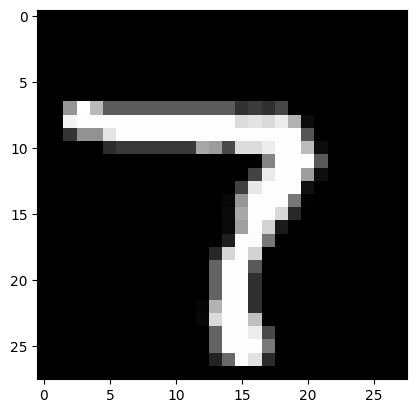

In [71]:
test_prediction(7, W1, b1, W2, b2, X_train, Y_train)